In [1]:
### Load Python libraries to work with
import pandas as pd, numpy as np
import requests, os, datetime, time, json, re
import ipyparallel as ipp
from ipyparallel import Client
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import folium
from folium import plugins
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# Read in data

## Method 1: Access data via API and SoQL

In [2]:
### Function that sends requests to website and returns responses
def read_data(myAPI):
    response = requests.get(myAPI)
    if response.status_code==200:
        print('Everything went okay, and the result has been returned')
    elif response.status_code==301:
        print('The server is redirecting you to a different endpoint')
    elif response.status_code==400:
        print('The server thinks you made a bad request')
    elif response.status_code==401:
        print('The server thinks you’re not authenticated')
    elif response.status_code==403:
        print('The resource you’re trying to access is forbidden')
    elif response.status_code==404:
        print('The resource you tried to access wasn’t found on the server')
    elif response.status_code==503:
        print('The server is not ready to handle the request')
    return response

In [3]:
### Try grabbing a small dataset
# myAPI = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?'
myAPI = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$offset=0&$limit=100'
start_time = time.time()
response = read_data(myAPI)
run_time = (time.time()-start_time)/60
print('This takes %s minutes to run' %run_time)

Everything went okay, and the result has been returned
This takes 0.6674161672592163 minutes to run


Grabbing 100 observations of all variables takes 0.7 minute. Thus grabbing 22.2 million observations takes more than 1 day. We will only select variables that enter our analysis in our requests.

In [4]:
### Grabbing selected columns to work with
### Example of the first million observations
myAPI = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$offset=0&$limit=1000000&$select=unique_key,created_date,closed_date,agency,agency_name,complaint_type,incident_zip,status,resolution_description,borough,latitude,longitude,location'
start_time = time.time()
response = read_data(myAPI)
run_time = (time.time()-start_time)/60
print('This takes %s minutes to run' %run_time)

Everything went okay, and the result has been returned
This takes 0.5362666805585226 minutes to run


In [5]:
### Convert API responses to dataframe
jsonresponse = json.dumps(response.json())
dict_train = json.loads(jsonresponse)
df = pd.DataFrame(dict_train)
### Save dataframe to disk
df.to_csv('NYC311ServiceRequests.csv',index=False)

In [6]:
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,incident_zip,status,resolution_description,borough,latitude,longitude,location
0,33617811,2016-06-17T15:44:41.000,2016-06-24T15:08:43.000,DOF,Condo or CoOp Unit,DOF Property - Reduction Issue,11354,Closed,See notes.,QUEENS,NaN,NaN,NaN
1,33617455,2016-06-17T10:01:35.000,2016-07-26T16:55:20.000,DOF,Personal Exemption Unit,DOF Property - Reduction Issue,11005,Closed,See notes.,QUEENS,NaN,NaN,NaN
2,33617386,2016-06-17T14:01:00.000,2016-06-17T14:01:00.000,DOT,Department of Transportation,Street Light Condition,NaN,Closed,Service Request status for this request is ava...,BRONX,NaN,NaN,NaN
3,33617442,2016-06-17T11:30:47.000,2016-06-20T10:22:11.000,DOF,Correspondence Unit,DOF Property - Request Copy,11366,Closed,The Department of Finance mailed the requested...,QUEENS,NaN,NaN,NaN
4,33617445,2016-06-17T18:41:14.000,2016-06-18T18:43:57.000,HPD,Department of Housing Preservation and Develop...,HPD Literature Request,NaN,Closed,The literature will be emailed within 24 hours...,Unspecified,NaN,NaN,NaN


## Method 2: Download a csv file of the full dataset and read in data

In [2]:
# ### Read in full dataset
# filename = '311_Service_Requests_from_2010_to_Present.csv'
# df = pd.read_csv(filename)
# ### Select columns to work with
# df = df[['Unique Key','Created Date','Closed Date','Agency','Agency Name','Complaint Type','Incident Zip','Status',
#          'Borough','Latitude','Longitude','Location']].copy()
# ### Change column names to be consistent with data from API
# dfcols = [a.lower().replace(' ','_') for a in df.columns]
# df.columns = dfcols
# df.to_csv('311_Service_Requests_selected_columns.csv',index=False)

In [3]:
### Read in data with selected columns
filename = '311_Service_Requests_selected_columns.csv'
df = pd.read_csv(filename,dtype={'incident_zip':'object'})
df.shape

(22162580, 12)

In [4]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'incident_zip', 'status', 'borough', 'latitude',
       'longitude', 'location'],
      dtype='object')

In [5]:
df[:2]

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,incident_zip,status,borough,latitude,longitude,location
0,38862011,04/04/2018 12:35:24 PM,04/25/2018 12:00:00 AM,DOB,Department of Buildings,Building/Use,11228.0,Closed,BROOKLYN,40.626471,-74.011787,"(40.6264713778687, -74.01178731070924)"
1,38862012,04/04/2018 09:50:12 AM,05/16/2018 12:00:00 AM,DOB,Department of Buildings,Building/Use,11435.0,Closed,QUEENS,40.706804,-73.808903,"(40.706803955197486, -73.808903305069)"


# Perform data cleaning and manipulation
Use parallel processing for faster computing
1. Find number of days between complaint and resolution
2. Determine what day of week for complaints
3. Remove bad observations (observations with invalid date format or observations with created date after closed date)

In [6]:
### Start IPython Clusters in the Jupyter Notebook
rc = Client()
lview = rc.load_balanced_view()     # Default load-balanced view
pnodes = len(rc.ids)
print('Number of processors: ',pnodes)

Number of processors:  16


In [7]:
### Function that segments data for parallel computing
def chunks(l, n):
   n = max(1, n)
   return [l[i:i + n] for i in range(0, len(l), n)]

In [8]:
@lview.parallel(block=True)
def _date_manipulation_(packet):
    ### Function that convert strings to different date formats
    import pandas as pd, numpy as np
    
    ### Unzip packet to Unique Keys, Created Dates, and Closed Dates
    UniqueKey, CreatedString, ClosedString = zip(*packet)
    
    ### Convert strings to dates, invalid parsing will be set as NaT
    CreatedDate = pd.to_datetime(CreatedString,errors='coerce')
    ClosedDate = pd.to_datetime(ClosedString,errors='coerce')
    DateOpen = CreatedDate.date
    DateClose = ClosedDate.date
    CreatedYear = CreatedDate.year
    CreatedMonth = CreatedDate.month
    CreatedDay = CreatedDate.day
    CreatedWeekday = CreatedDate.strftime('%A')
    ClosedYear = ClosedDate.year
    ClosedMonth = ClosedDate.month
    ClosedDay = ClosedDate.day
    ClosedWeekday = ClosedDate.strftime('%A')
    ResolvedDays = (ClosedDate-CreatedDate).days
    
    outputs = list(zip(UniqueKey,CreatedDate,CreatedYear,CreatedMonth,CreatedDay,CreatedWeekday,DateOpen,
                       ClosedDate,ClosedYear,ClosedMonth,ClosedDay,ClosedWeekday,DateClose,ResolvedDays))
    
    return outputs

In [9]:
UniqueKey = list(df['unique_key'])
CreatedString = list(df['created_date'])
ClosedString = list(df['closed_date'])
### Prepare the inputs for the parallel process
inputs = list(zip(UniqueKey,CreatedString,ClosedString))
len(inputs)

22162580

In [10]:
### Split dates for each node
iterspernode = 1
packet = chunks(inputs,max(int(len(inputs)/(pnodes*iterspernode)),1))
'each node gets {} dates'.format(len(packet[0]))

'each node gets 1385161 dates'

In [11]:
### Convert strings to dates in parallel
start_time = time.time()
outputs = _date_manipulation_.map(packet)
run_time = (time.time()-start_time)/60
print('This takes %s minutes to run' %run_time)

This takes 9.825091179211935 minutes to run


In [12]:
### Get final list of dates
output = [item for l in outputs for item in l]
### Convert output to dataframe
outputdf = pd.DataFrame(output)
outputdf.columns = ['unique_key','CreatedDate','CreatedYear','CreatedMonth','CreatedDay','CreatedWeekday',
                    'DateOpen','ClosedDate','ClosedYear','ClosedMonth','ClosedDay','ClosedWeekday','DateClose',
                    'ResolvedDays']
### Merge new dates with original data
df = pd.merge(df,outputdf,how='inner',on=['unique_key'])
len(df)

22162580

In [13]:
### Remove bad date observations
data = df[(df['ResolvedDays']>=0)|(pd.isnull(df['ResolvedDays']))]
### Get rid of erroneously marked closed date observations
today = pd.to_datetime(datetime.date.today())
data = data[(data.ClosedDate<=today)|(data.ClosedDate.isnull())]
### Sort data by date
data.sort_values(by=['CreatedDate','ClosedDate'],inplace=True)
len(data)

21925508

In [14]:
### Find average numbers of complaint per weekday
data_weekdayCount = data.groupby(['CreatedYear','CreatedMonth','CreatedDay','CreatedWeekday']).agg({'unique_key':'count','ResolvedDays':'mean'}).reset_index()
data_weekdayAvg = data_weekdayCount[['CreatedWeekday','unique_key']].groupby(['CreatedWeekday']).mean().rename(columns={'unique_key':'average'})

In [15]:
print('Number of service requests: ',len(data))
print('Number of complaint types:',len(set(data['complaint_type'])))
print('Average number of service requests on Monday: ',data_weekdayAvg.loc['Monday'][0])
print('Average number of service requests on Tuesday: ',data_weekdayAvg.loc['Tuesday'][0])
print('Average number of service requests on Wednesday: ',data_weekdayAvg.loc['Wednesday'][0])
print('Average number of service requests on Thursday: ',data_weekdayAvg.loc['Thursday'][0])
print('Average number of service requests on Friday: ',data_weekdayAvg.loc['Friday'][0])
print('Average number of service requests on Saturday: ',data_weekdayAvg.loc['Saturday'][0])
print('Average number of service requests on Sunday: ',data_weekdayAvg.loc['Sunday'][0])
print('Average number of days to resolve issues: ',data['ResolvedDays'].mean())

Number of service requests:  21925508
Number of complaint types: 437
Average number of service requests on Monday:  6526.617590822179
Average number of service requests on Tuesday:  6738.824091778202
Average number of service requests on Wednesday:  6660.3218390804595
Average number of service requests on Thursday:  6504.879310344828
Average number of service requests on Friday:  6252.409177820267
Average number of service requests on Saturday:  4803.455066921606
Average number of service requests on Sunday:  4461.242829827916
Average number of days to resolve issues:  15.576812043327449


# Analysis

## Descriptive

### Find common complaints

Text(0.5, 1.0, 'Distribution of Complaint Type Incidents')

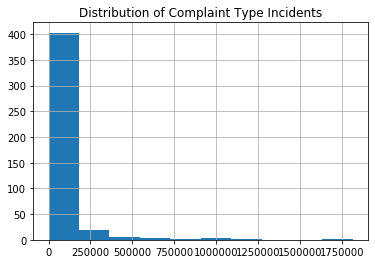

In [16]:
complainttypes = data.groupby('complaint_type')['unique_key'].count().reset_index()
complainttypes['unique_key'].hist()
plt.title('Distribution of Complaint Type Incidents')
### Majority of complaint types are uncommon

In [17]:
pct = .02
threshold = len(data)*pct
print('Complaint types that represent at least {:.2f}% of the data have at least {:.2f} observations'.format(pct*100,threshold))

Complaint types that represent at least 2.00% of the data have at least 438510.16 observations


In [18]:
commoncomplaints = complainttypes.loc[complainttypes['unique_key']>=threshold, 'complaint_type']
'There are {} common complaints, those representing more than {:.2f}% of all complaints'.format(len(commoncomplaints),pct*100)

'There are 14 common complaints, those representing more than 2.00% of all complaints'

In [19]:
re.sub('[\[\]]', '','Common complaints: {}'.format(list(commoncomplaints)))

"Common complaints: 'Blocked Driveway', 'GENERAL CONSTRUCTION', 'General Construction/Plumbing', 'HEAT/HOT WATER', 'HEATING', 'Illegal Parking', 'Noise', 'Noise - Residential', 'Noise - Street/Sidewalk', 'PLUMBING', 'Street Condition', 'Street Light Condition', 'UNSANITARY CONDITION', 'Water System'"

### Find open/closed complaints by date and type

In [20]:
### Get complaint open/closure counts by date and type
opens = data[data['complaint_type'].isin(commoncomplaints)].groupby(['DateOpen','complaint_type'])['unique_key'].count().unstack('complaint_type').reset_index()
closures = data[data['complaint_type'].isin(commoncomplaints)].groupby(['DateClose','complaint_type'])['unique_key'].count().unstack('complaint_type').reset_index()
opens.columns = ['date'] + [re.sub('[ \/\\()]','','open_{}'.format(c)) for c in opens.columns[1:]]
closures.columns = ['date'] + [re.sub('[ \/\\()]','','close_{}'.format(c)) for c in closures.columns[1:]]
daily_by_type = opens.merge(closures,how='outer',on=['date'])
typecols = [c.replace('open_','') for c in opens.columns[1:]]
daily_by_type.set_index('date',inplace=True)

In [21]:
netcols = list()
cumcols = list()
for c in typecols:
    ### Daily net complaint (+ open - close)
    daily_by_type['net_{}'.format(c)] = daily_by_type['open_{}'.format(c)]-daily_by_type['close_{}'.format(c)]
    netcols.append('net_{}'.format(c))
    ### Daily cumulative net open complaints
    daily_by_type['cum_{}'.format(c)] = daily_by_type['net_{}'.format(c)].cumsum()
    cumcols.append('cum_{}'.format(c))

In [22]:
### Duration of complaint resolutions (average time to close a complaint by date)
# durations = data[data['complaint_type'].isin(commoncomplaints)].groupby(['DateOpen','complaint_type'])['ResolvedDays'].mean().unstack('complaint_type').reset_index()
durations = data[data['complaint_type'].isin(commoncomplaints)].groupby(['DateOpen','complaint_type'])['ResolvedDays'].mean().apply(lambda x: np.log(x+1)).unstack('complaint_type').reset_index()
durations.columns = ['date']+['duration_{}'.format(c) for c in typecols]
durations.set_index('date',inplace=True)
durcols = ['duration_{}'.format(c) for c in typecols]

In [23]:
### Moving average (smooth)
period = 30
daily_by_type_smooth = daily_by_type.rolling(period).mean()
conditions = (daily_by_type_smooth.index>=pd.to_datetime('1/31/2010'))&(daily_by_type_smooth.index<pd.to_datetime('1/1/2019'))

Text(0.5, 1.0, 'Historical Net Complaints')

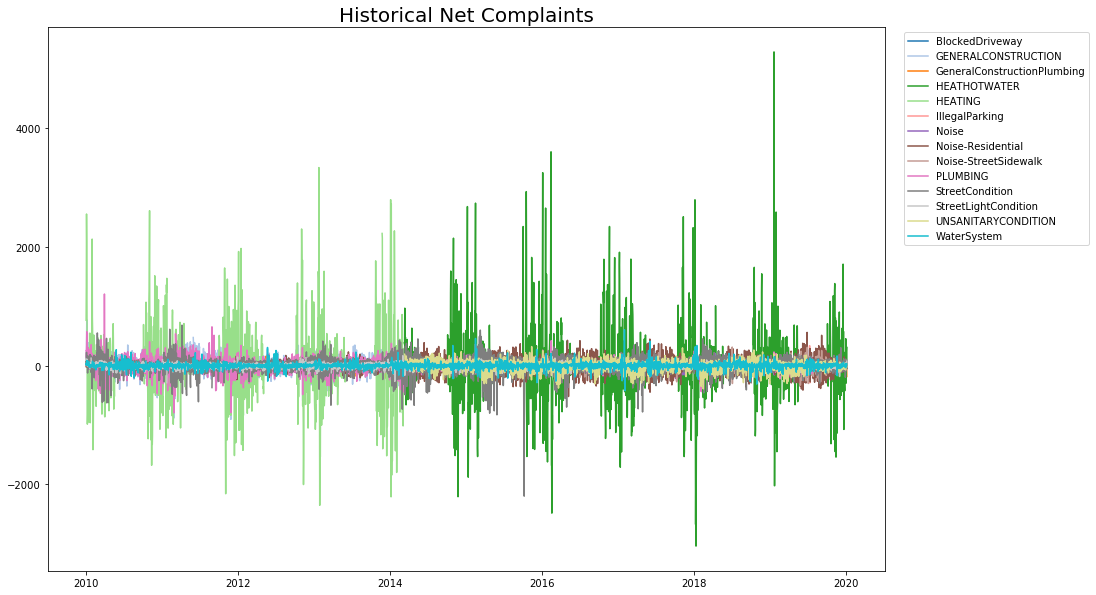

In [25]:
# from matplotlib import cm
cmap = cm.get_cmap('tab20')

fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(netcols):
    ax.plot(daily_by_type[col],c=cmap(i/len(netcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical Net Complaints',fontsize=20)

Text(0.5, 1.0, 'Historical Net Complaints Smoothed 30-day M.A.')

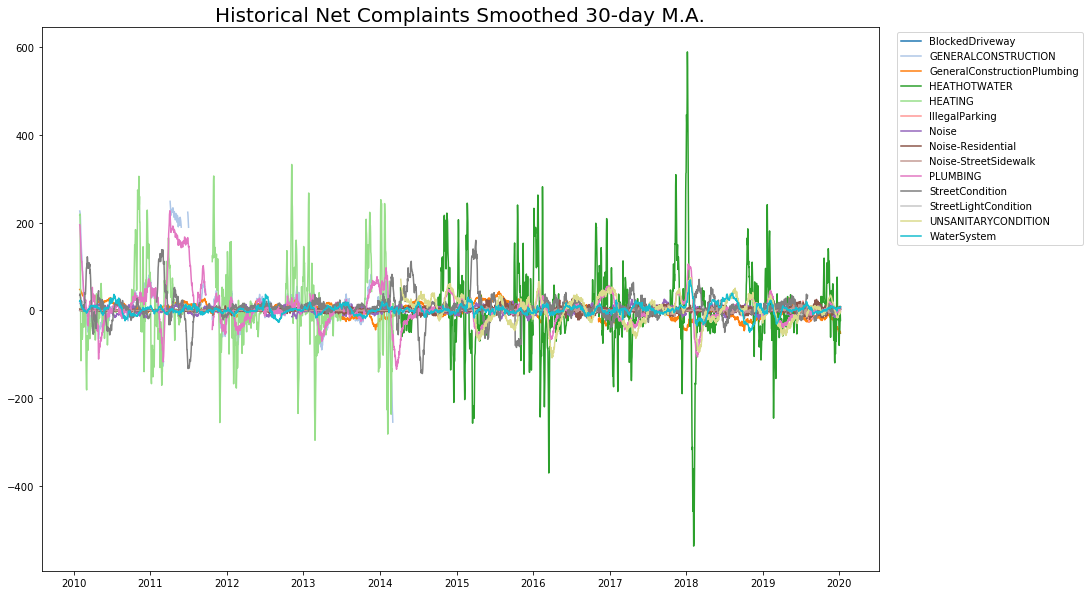

In [26]:
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(netcols):
    ax.plot(daily_by_type_smooth[col],c=cmap(i/len(netcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical Net Complaints Smoothed {}-day M.A.'.format(period),fontsize=20)

High volatility suggests inconsistent/poor management of job queue. Prior to 2015, heating complaints were the most commonly highly volatile while after 2015, heat hot water complaints have become the most volatile, this is perhaps due to the combination of the 2 codes.

Text(0.5, 1.0, 'Historical 30 Day Moving Average of Open Complaints')

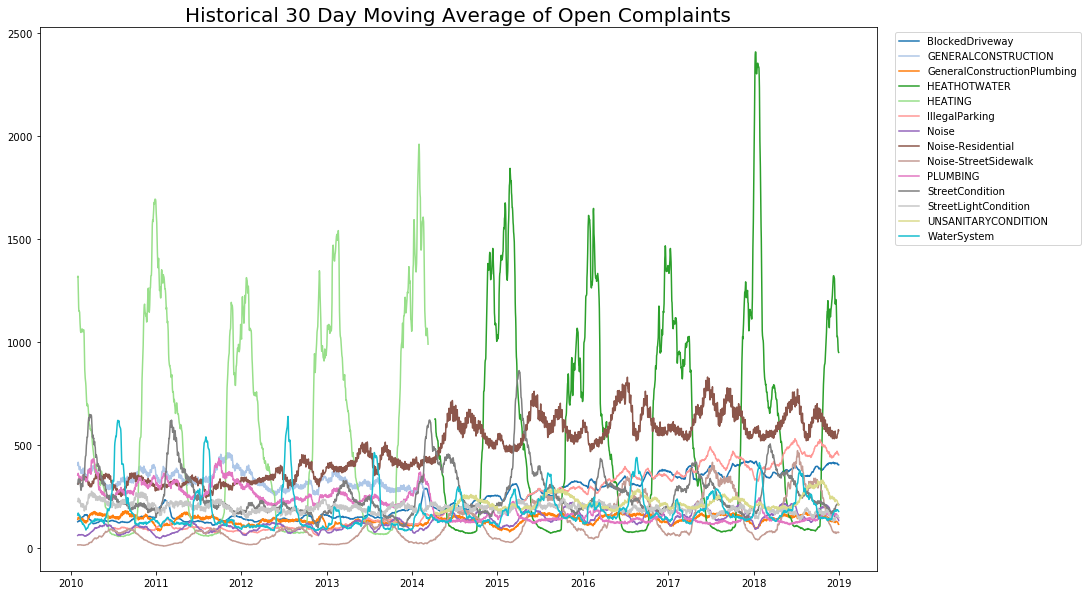

In [27]:
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(typecols):
    ax.plot(daily_by_type_smooth.loc[conditions,'open_{}'.format(col)],c=cmap(i/len(typecols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical {} Day Moving Average of Open Complaints'.format(period),fontsize=20)

There is seasonality associated with hot water and heating complaints during winter.

Text(0.5, 1.0, 'Historical Cumulative Net Complaints')

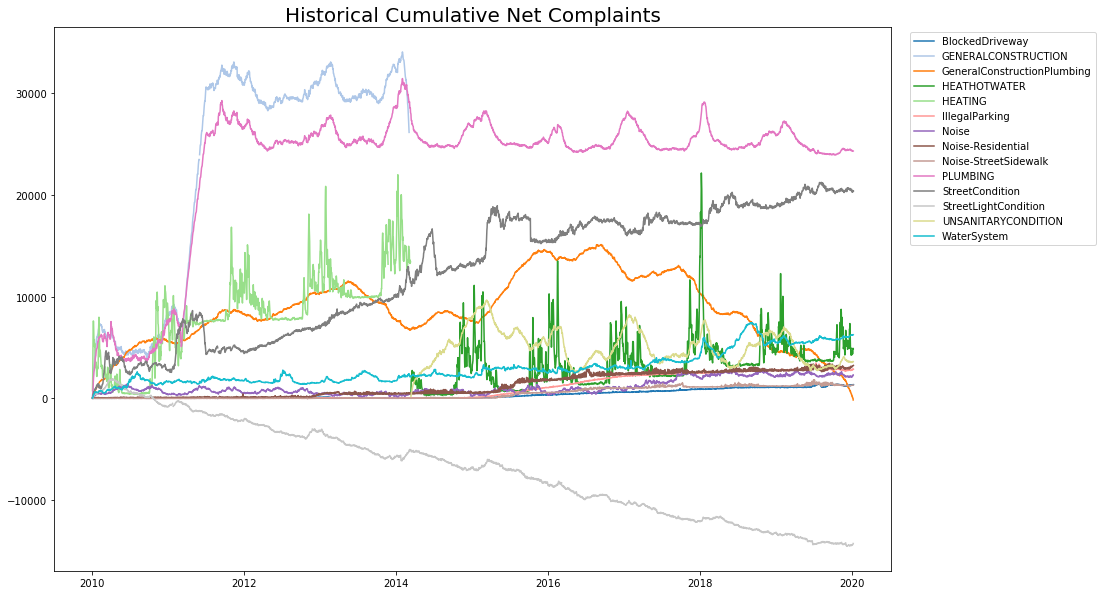

In [28]:
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(cumcols):
    ax.plot(daily_by_type[col],c=cmap(i/len(cumcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical Cumulative Net Complaints',fontsize=20)

Text(0.5, 1.0, 'Historical Cumulative Net Complaints Smoothed 30-day M.A.')

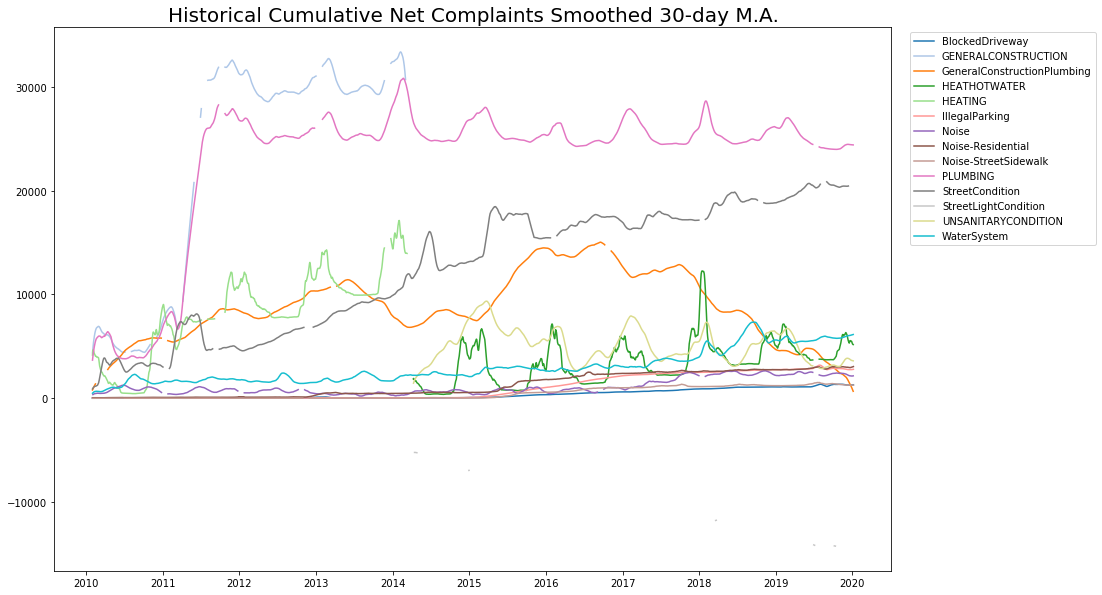

In [29]:
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(cumcols):
    ax.plot(daily_by_type_smooth[col],c=cmap(i/len(cumcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical Cumulative Net Complaints Smoothed {}-day M.A.'.format(period),fontsize=20)

Complaints about illegal parking and street conditions have gone up, while complaints about general construction and plumbing have gone down.

Text(0.5, 1.0, 'Historical log(Duration) of Complaint Resolutions')

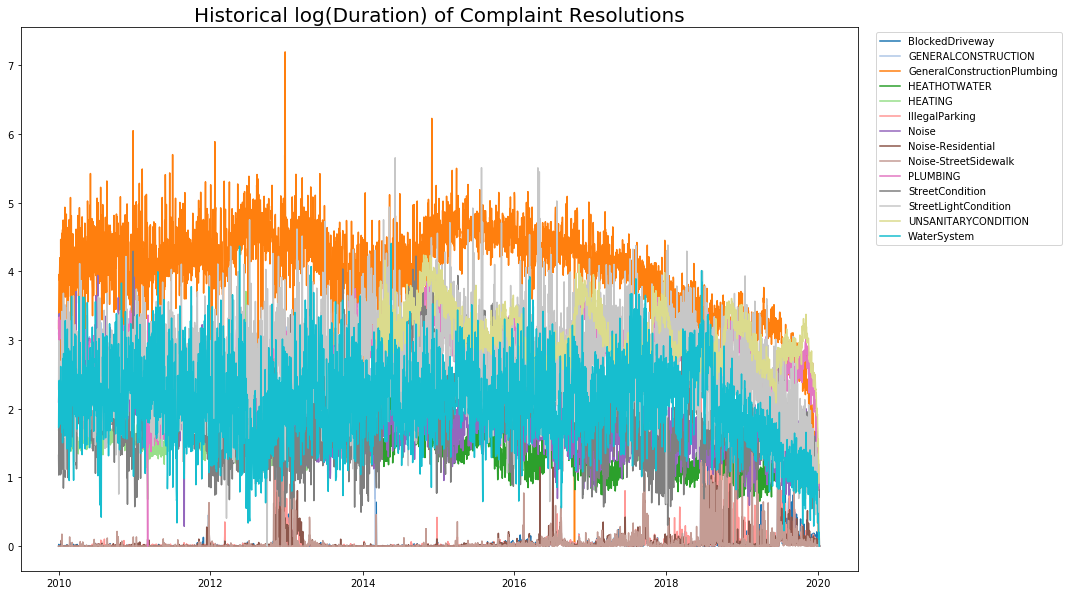

In [30]:
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(durcols):
    ax.plot(durations[col],c=cmap(i/len(durcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical log(Duration) of Complaint Resolutions',fontsize=20)

Text(0.5, 1.0, 'Historical log(30 Day Moving Average Duration of Complaint Resolutions)')

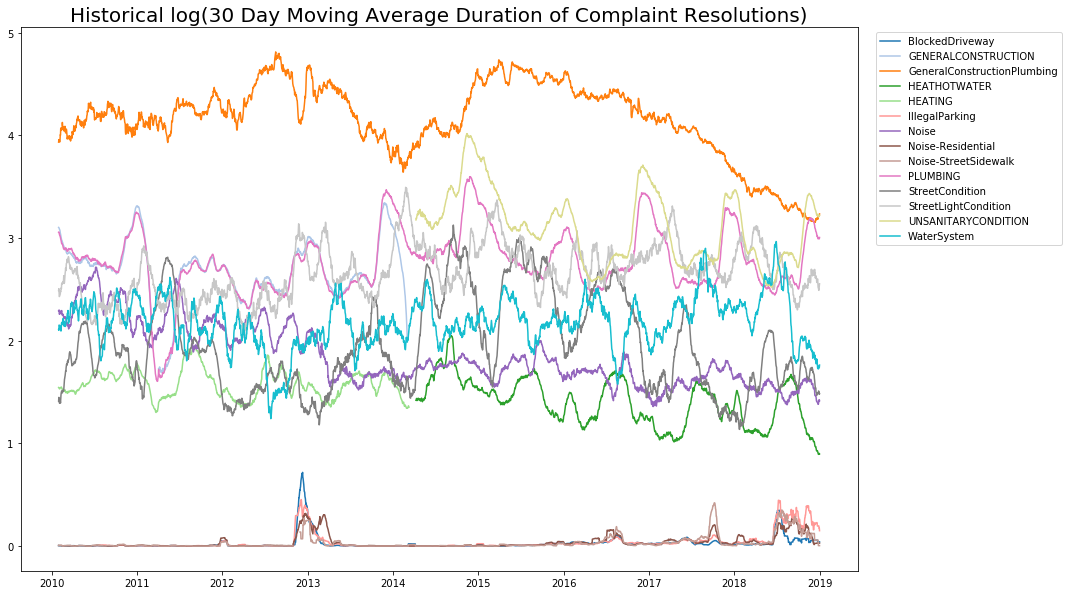

In [31]:
period = 30
duration_smooth = durations.rolling(period).mean()
conditions = (duration_smooth.index>=pd.to_datetime('1/31/2010'))&(duration_smooth.index<pd.to_datetime('1/1/2019'))
fig,ax = plt.subplots(1,figsize=(15,10))
for i,col in enumerate(durcols):
    ax.plot(duration_smooth.loc[conditions,col],c=cmap(i/len(durcols)))
plt.legend(typecols,loc='upper right',bbox_to_anchor=(1.25,1))
plt.title('Historical log({} Day Moving Average Duration of Complaint Resolutions)'.format(period),fontsize=20)

Response time for general construction and plumbing complaints has improved, while that of illegal parking and unsanitary condition has become longer.

## Geographic - temporal variation in complaints and response times

### Match zipcodes in the data with actual zipcodes

In [32]:
### Download json zip codes from https://github.com/OpenDataDE/State-zip-code-GeoJSON
gjsonpath= './State-zip-code-GeoJSON-master/'
gjsonfiles = os.listdir(gjsonpath)
gjsonfiles = [gjsonpath+f for f in gjsonfiles  if ('ny' in f)|('nj' in f)]
gjsonfiles

['./State-zip-code-GeoJSON-master/nj_new_jersey_zip_codes_geo.min.json',
 './State-zip-code-GeoJSON-master/ny_new_york_zip_codes_geo.min.json']

In [33]:
with open(gjsonfiles[1],'r') as f:
    nygjson = json.loads(f.read())
with open(gjsonfiles[0],'r') as f:
    njgjson = json.loads(f.read())

In [34]:
### Get dataframe of zipcodes by state (New York and New Jersey)
zipcodes = list()
for i,z in enumerate(nygjson.get('features')):
    zipcodes.append(('ny',i,float(z.get('properties').get('ZCTA5CE10').split('-')[0])))
for i,z in enumerate(njgjson.get('features')):
    zipcodes.append(('nj',i,float(z.get('properties').get('ZCTA5CE10').split('-')[0])))
zipcodes = pd.DataFrame(zipcodes)
zipcodes.columns = ['state','ind','zip']
zips = list(zipcodes.zip.unique())

In [35]:
### Find bad zipcodes in the data
badzips = list(data['incident_zip'].unique())
badzips = [z for z in badzips if type(z) not in {float,int}]
### Convert bad zipcodes to good zipcodes
goodzips  = [re.findall('[0-9]{5}',z) for z in badzips]
zipdict = {badzips[i]:float(z[0]) for i,z in enumerate(goodzips) if len(z)>0}

In [36]:
### Convert bad zipcodes in the data to the right zipcodes
data.loc[data['incident_zip'].isin(zipdict),'zip'] = data.loc[data['incident_zip'].isin(zipdict),'incident_zip'].apply(lambda x: zipdict.get(x))
cond = data['incident_zip'].apply(lambda x: type(x)==float)
data.loc[cond,'zip'] = data.loc[cond,'incident_zip']
cond = data['incident_zip'].apply(lambda x: type(x)==int)
data.loc[cond,'zip'] = data.loc[cond,'incident_zip'].map(float)

In [37]:
### Zipcodes in the data that are in actual zips
actualzips = set(map(float,zips))
data.zip.isin(actualzips).sum()/len(data)

0.9427257968207624

In [38]:
### Observations in the data with zips, almost identical coverage
data.zip.notnull().sum()/len(data)

0.9461451930783086

### Annual level major complaint type count and response delay by zipcode

In [39]:
cond = data['complaint_type'].isin(commoncomplaints)&data.zip.isin(actualzips)
annual_complaint_by_zip = data[cond].groupby(['CreatedYear','zip','complaint_type'])['unique_key'].count().reset_index()
annual_resolution_by_zip = data[cond].groupby(['CreatedYear','zip','complaint_type'])['ResolvedDays'].mean().reset_index()

#### Example of noise complaints

In [40]:
cols = [c for c in annual_complaint_by_zip['complaint_type'].unique() if 'noise -' in c.lower()]
temp = annual_complaint_by_zip[annual_complaint_by_zip['complaint_type'].isin(cols)]

In [41]:
### Residential noise complaints by zip over time
res = temp[temp['complaint_type']=='Noise - Residential'].copy()
res['color_scale'] = (res['unique_key'].map(np.log)-res['unique_key'].map(np.log).min())/(res['unique_key'].map(np.log).max()-res['unique_key'].map(np.log).min())
cmap = cm.get_cmap('RdPu')
res['color'] = res.color_scale.map(cmap).map(mpl.colors.to_hex)
res = res.merge(zipcodes,how='left',on='zip')

In [42]:
### Convert geo data to proper format
features = list()
newind = dict()
for i,r in res[['zip','state','ind']].drop_duplicates().reset_index(drop=True).iterrows():
    z,state,ind = r.zip,r.state,r.ind
    if state=='ny':
        g = nygjson.get('features')[ind].copy()
    else:
        g = njgjson.get('features')[ind].copy()
#     geo = g.get('geometry').get('coordinates')
    g['id'] = str(i)
    features.append(g)
#     features.append({'type':'Feature','id':str(i),'geometry':{'coordinates':geo,'type':'Polygon'}})
    newind[ind] = str(i)
res['newind'] = res.ind.map(newind)
nycjson = {'type':'FeatureCollection','features':features}
nycjson = json.dumps(nycjson)

In [43]:
### Convert data to match json data format
styledicts_res = dict()
for ind in res.newind.unique():
    tdata = dict()
    for i,r in res[res.newind==ind].iterrows():
        t,c = r.CreatedYear,r.color
        tstamp = int((pd.to_datetime(['{}-1-2'.format(t)],utc=True).astype(int)/ 10**9)[0])
        tdata[tstamp]={'color':c,'opacity':1}
    styledicts_res[ind] = tdata

In [44]:
### Complaint level over time
m = folium.Map(location=[40.7,-74],zoom_start=10,tiles='Stamen Toner' )
m.add_child(plugins.TimeSliderChoropleth(nycjson,styledict=styledicts_res,overlay=True,name='Residential Noise Complaints'))

#### Generate zip-over-time complaint volume for all main categories - save in figures as html files
See the graphs here:
1. [Blocked driveway](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_blockeddriveway_complaints.html)
2. [General construction](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_generalconstruction_complaints.html)
3. [General construction/plumbing](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_generalconstructionplumbing_complaints.html)
4. [Heat/hot water](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_heathotwater_complaints.html)
5. [Heating](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_heating_complaints.html)
6. [Illegal parking](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_illegalparking_complaints.html)
7. [Residential noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_noise-residential_complaints.html)
8. [Street/sidewalk noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_noise-streetsidewalk_complaints.html)
9. [Noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_noise_complaints.html)
10. [Plumbing](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_plumbing_complaints.html)
11. [Street condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_streetcondition_complaints.html)
12. [Street light condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_streetlightcondition_complaints.html)
13. [Unsanitary condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_unsanitarycondition_complaints.html)
14. [Water system](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Complaints_by_zip/annual_watersystem_complaints.html)

In [45]:
complainttypes = annual_complaint_by_zip['complaint_type'].unique()

In [46]:
features = list()
newind = dict()
for i,r in res[['zip','state','ind']].drop_duplicates().reset_index(drop=True).iterrows():
    z,state,ind = r.zip,r.state,r.ind
    if state == 'ny':
        g = nygjson.get('features')[ind].copy()
    else:
        g = njgjson.get('features')[ind].copy()
#     geo = g.get('geometry').get('coordinates')
    g['id'] = str(i)
    features.append(g)
#     features.append({'type':'Feature','id':str(i),'geometry':{'coordinates':geo,'type':'Polygon'}})
    newind[ind] = str(i)
nycjson = {'type':'FeatureCollection','features':features}
nycjson = json.dumps(nycjson)

In [47]:
cmap = cm.get_cmap('RdPu')
for comp in complainttypes:
    temp = annual_complaint_by_zip.loc[annual_complaint_by_zip['complaint_type']==comp].copy()
    logscale = temp['unique_key'].map(np.log)
    temp['color_scale'] = (logscale-logscale.min())/(logscale.max()-logscale.min())
    
    temp['color'] = temp.color_scale.map(cmap).map(mpl.colors.to_hex)
    temp = temp.merge(zipcodes,how='left',on='zip')
    temp['newind'] = temp.ind.map(newind)
    
    styledicts = dict()    
    for ind in temp.newind.unique():
        if pd.notnull(ind):
            tdata = dict()
            for i,r in temp[temp.newind==ind].iterrows():
                t, c = r.CreatedYear,r.color
                tstamp = int((pd.to_datetime(['{}-1-2'.format(t)],utc=True).astype(int)/ 10**9)[0])
                tdata[tstamp]={'color':c,'opacity':.5}
            styledicts[ind] = tdata
    ### Complaint level over time
    m = folium.Map(location=[40.7,-74],zoom_start=10,tiles='Stamen Toner')
    f = re.sub('[ \/\\()]','',comp.lower())
    m.add_child(plugins.TimeSliderChoropleth(nycjson,styledict=styledicts,overlay=True,name=f))    
    m.save('./figures/complaints_by_zip/annual_{}_complaints.html'.format(f))

#### Generate zip-over-time response speed for all main categories - save in figures as html files
See the graphs here:
1. [Blocked driveway](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_blockeddriveway_avg_resolution_days.html)
2. [General construction](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_generalconstruction_avg_resolution_days.html)
3. [General construction/plumbing](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_generalconstructionplumbing_avg_resolution_days.html)
4. [Heat/hot water](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_heathotwater_avg_resolution_days.html)
5. [Heating](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_heating_avg_resolution_days.html)
6. [Illegal parking](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_illegalparking_avg_resolution_days.html)
7. [Residential noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_noise-residential_avg_resolution_days.html)
8. [Street/sidewalk noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_noise-streetsidewalk_avg_resolution_days.html)
9. [Noise](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_noise_avg_resolution_days.html)
10. [Plumbing](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_plumbing_avg_resolution_days.html)
11. [Street condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_streetcondition_avg_resolution_days.html)
12. [Street light condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_streetlightcondition_avg_resolution_days.html)
13. [Unsanitary condition](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_unsanitarycondition_avg_resolution_days.html)
14. [Water system](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Resp_delay_by_zip/annual_watersystem_avg_resolution_days.html)

In [49]:
cmap = cm.get_cmap('RdPu')
for comp in complainttypes:
    temp = annual_resolution_by_zip.loc[annual_resolution_by_zip['complaint_type']==comp].copy()
    logscale = temp['ResolvedDays'].apply(lambda x: np.log(x+1))
    temp['color_scale'] = (logscale-logscale.min())/(logscale.max()-logscale.min())
    
    temp['color'] = temp.color_scale.map(cmap).map(mpl.colors.to_hex)
    temp = temp.merge(zipcodes,how='left',on='zip')
    temp['newind'] = temp.ind.map(newind)
    
    styledicts = dict()    
    for ind in temp.newind.unique():
        if pd.notnull(ind):
            tdata = dict()
            for i,r in temp[temp.newind==ind].iterrows():
                t, c = r.CreatedYear,r.color
                tstamp = int((pd.to_datetime(['{}-1-2'.format(t)],utc=True).astype(int)/ 10**9)[0])
                tdata[tstamp]={'color':c,'opacity':.5}
            styledicts[ind] = tdata
    ### Response speed over time
    m = folium.Map(location=[40.7,-74],zoom_start=10,tiles='Stamen Toner')
    f = re.sub('[ \/\\()]', '',comp.lower())
    m.add_child(plugins.TimeSliderChoropleth(nycjson,styledict=styledicts,overlay=True,name=f))    
    m.save('./figures/resp_delay_by_zip/annual_{}_avg_resolution_days.html'.format(f))

# Predicting Delays in Response

Dependent variables:
1. ResolvedDays

Quantitative variables for correlation map:
1. Net outstanding complaints by day
2. Cumulative net outstanding complaints by day (lagged cumulative + new incoming)
3. Number of incoming complaints by day
4. Number of resolved complaints by day

Independent variables:
1. Number of complaints
2. Seasonality (month, weekday)
3. Complaint type
4. Location
5. Agency

## Make correlation heatmap for quatitative variables

In [50]:
### Calculate quantitative variables
dailyincoming = data.groupby(by=['DateOpen'])['unique_key'].count().reset_index().rename(columns={'DateOpen':'Date',
                                                                                                  'unique_key':'DailyIncoming'})
dailyfinished = data.groupby(by=['DateClose'])['unique_key'].count().reset_index().rename(columns={'DateClose':'Date',
                                                                                                   'unique_key':'DailyFinished'})
netdaily = dailyincoming.merge(dailyfinished,how='outer',on='Date')
netdaily['DailyNetOutstanding'] = netdaily['DailyIncoming']-netdaily['DailyFinished']
PreviousFinished = netdaily['DailyFinished'][:-1].to_list()
PreviousFinished.insert(0,0)
netdaily['DailyCumulativeOutstanding'] = netdaily['DailyIncoming'].cumsum()-PreviousFinished

In [51]:
data = data.merge(netdaily.rename(columns={'Date':'DateOpen'}),how='outer',on='DateOpen')
print(data.shape)

(21925508, 30)


In [52]:
### Reference: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20,220,n=n_colors) # Create the palette
color_min,color_max = [-1,1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val-color_min))/(color_max-color_min) # Position of value in the input range, relative to the length of the input range
    ind = int(val_position*(n_colors-1)) # Target index in the color palette
    return palette[ind]

def heatmap(x,y,color,size,figsize=(10,10),title='Correlation Heatmap',savefig=False,fpath=''):
    fig,ax = plt.subplots(figsize=figsize)
    
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(20,220,n=n_colors) # Create the palette
    color_min,color_max = [-1,1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    ### Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    ax.scatter(
        x = x.map(x_to_num),
        y = y.map(y_to_num),
        s = size*size_scale,
        c = color, # Vector of square color values, mapped to color palette
        marker = 's')

    ### Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels,rotation=45,horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

    ax.grid(False,'major')
    ax.grid(True,'minor')
    ax.set_xticks([t+0.5 for t in ax.get_xticks()],minor=True)
    ax.set_yticks([t+0.5 for t in ax.get_yticks()],minor=True)
    
    ax.set_xlim([-0.5,max([v for v in x_to_num.values()])+0.5]) 
    ax.set_ylim([-0.5,max([v for v in y_to_num.values()])+0.5])
    ax.set_title(title)
    if (savefig==True)|(fpath!=''):
        fig.savefig(fpath,bbox_inches='tight',dpi=300)

In [53]:
### Define variables of interest
cols = ['ResolvedDays','DailyIncoming','DailyFinished','DailyNetOutstanding','DailyCumulativeOutstanding']

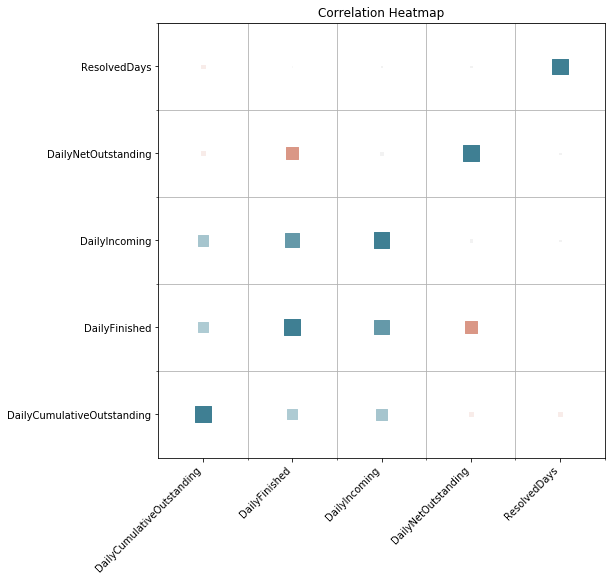

In [54]:
### Make correlation table
corr = data[cols].corr()
corr = pd.melt(corr.reset_index(),id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x','y','value']
corr = corr[corr.value.notnull()]
corr['color'] = corr.value.map(value_to_color)

### Draw heatmap
heatmap(
    x = corr['x'],
    y = corr['y'],
    color = corr['color'],
    size = corr['value'].abs()*.5,
    figsize = (8,8),
    fpath = 'figures/misc/correlation_heatmap.png'
)

[Correlation heatmap](https://vanvan01.s3-us-west-2.amazonaws.com/Data/NYC311ServiceRequests/Figures/Misc/correlation_heatmap.png)

## Regression model
ResolvedDays ~ DailyComplaintVolume + CreatedYear + CreatedMonth + CreatedWeekday + CommonComplaint + Agency + Borough

In [55]:
regressiondata = data[['ResolvedDays','DailyIncoming','CreatedYear','CreatedMonth','CreatedWeekday',
                              'complaint_type','agency','borough']].copy()
regressiondata['CommonComplaint'] = regressiondata['complaint_type'].apply(lambda x: 1 if x in set(commoncomplaints) else 0)
regressiondata.drop('complaint_type',axis=1,inplace=True)
regressiondata = regressiondata[pd.notnull(regressiondata['ResolvedDays'])].copy()
regressiondata.shape

(21316833, 8)

In [56]:
### Convert categorical variables to dummies
YearDummies = pd.get_dummies(regressiondata['CreatedYear'])
YearDummies.drop(labels=[2020],axis=1,inplace=True)
MonthDummies = pd.get_dummies(regressiondata['CreatedMonth'])
MonthDummies.drop(labels=[12],axis=1,inplace=True)
WeekdayDummies = pd.get_dummies(regressiondata['CreatedWeekday'])
WeekdayDummies.drop(labels=['Sunday'],axis=1,inplace=True)
AgencyDummies = pd.get_dummies(regressiondata['agency'])
AgencyDummies.drop(labels=['ACS'],axis=1,inplace=True)
BoroughDummies = pd.get_dummies(regressiondata['borough'])
BoroughDummies.drop(labels=['Unspecified'],axis=1,inplace=True)
RegData = pd.concat([regressiondata,YearDummies,MonthDummies,WeekdayDummies,AgencyDummies,BoroughDummies],axis=1)
### Define dependent variable and regressors
y = RegData['ResolvedDays']
X = RegData.drop(['ResolvedDays','CreatedYear','CreatedMonth','CreatedWeekday','agency','borough'],axis=1)

In [57]:
### Fit model
start_time = time.time()
RegResult = sm.OLS(y,X).fit()
run_time = (time.time()-start_time)/60
print('This takes %s minutes to run' %run_time)

This takes 1.6141194740931193 minutes to run


In [58]:
print(RegResult.summary())

                                 OLS Regression Results                                
Dep. Variable:           ResolvedDays   R-squared (uncentered):                   0.133
Model:                            OLS   Adj. R-squared (uncentered):              0.133
Method:                 Least Squares   F-statistic:                          6.079e+04
Date:                Mon, 13 Jan 2020   Prob (F-statistic):                        0.00
Time:                        01:00:26   Log-Likelihood:                     -1.2110e+08
No. Observations:            21316833   AIC:                                  2.422e+08
Df Residuals:                21316779   BIC:                                  2.422e+08
Df Model:                          54                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

1. If a complaint is among the 14 most common complaints, the duration from the request to the resolution is significantly longer. This could be due to the understaffing problem.
2. Over the years, the duration gets shorter.
3. Duration in December and January is longer than the previous two months (October, November) or the following two months (February, March). This could be due to the holiday season.
4. Weekday durations are longer than weekend durations.
5. Duration also varies by location and agency.